# Earthscope MsPASS Short Course Session 1
# MsPASS Fundamentals
## *Gary L. Pavlis, Indiana University and Yinzhi (Ian) Wang, TACC*

## Overview

## Preliminaries
### Students enrolled in the class using GeoLab site
If you are reading this you are ready to go.  You should also have a second tab open for the notebook "Homework1.ipynb".  You will be doing some of the questions in that notebook during the class session today.  If you don't complete all of those during the class session today you can complete them later.   There are additional questions that are true homework.   You will be instructed on how to submit your work.      

If you are reading this during the Earthscope-sponsored workshop you can fetch the data for this exercise more quickly with the following cell
You should see output as wget runs. 

Alternatively, you can run the notebook found in this directory called "data_retrieval_mspass2024course.ipynb".  It uses obspy's downloader with web services but is about 2 orders of magnitude slower than wget.  That, by the way, is a lesson in one reason why Earthscope is moving to a cloud-base data delivery system.  


In [ ]:
!mkdir -p wf && cd wf && for i in {0..19}; do wget https://essc-mspass2024.s3.us-east-2.amazonaws.com/Event_${i}.msd;done

#### Start MongoDB server
In the GeoLab, we don't have a MongoDB locally running. We need to launch the MongoDB server manually in a separate terminal.
```
mkdir db && mongod --dbpath ./db --logpath ./db/log
```

### Students not enrolled in course or who are running this after pulling this tutorial from github

This tutorial assumes you have already done the following:
1.  Installed docker.
2.  Run the commmand `docker pull mspass/mspass`
3.  In a terminal cd to the working directory where you saved this tutorial.
4.  Launched docker with this incantation:
```
  docker run -p 8888:8888 \
      --mount src=`pwd`,target=home,type=bind mspass/mspass
```
6.  Connected to the container to get this tutorial running as described in the __[User Manual](https://www.mspass.org/getting_started/run_mspass_with_docker.html)__.

If you are running this during the Earthscope course you can use the wget incantation above to retrieve the waveform files required for this tutorial.  If those files are no longer there you can run the notebook found in this directory called "data_retrieval_mspass2024course.ipynb".  It uses obspy's downloader with web services but is about 2 orders of magnitude slower than wget with the prestaged files.  That, by the way, is a lesson in one reason why Earthscope is moving to a cloud-base data delivery system.  

## Fetching Data from Earthscope (IRIS)
### Source Data

This notebook focuses on event handling as it is the most common need in the community. I would note, however, that continuuous waveform processing is also a feature of MsPASS but the problem of handling the larger data volumes inherent in studies using continuous ddata does not mesh with the constraints of this workshop. The volumes handled here are not trivial but are small by modern standards. I emphasize current development efforts at Earthscope are expect to soon change the rules. With expected changes the model is expected to evolve to do make it preferable to do the kind of work in this notebook on the same cloud system that will host the Earthscope data.

For this tutorial we will focus on big events recorded by the TA in the calendar year 2011. The MsPASS package includes obspy so we first use obspy's web services functions to get a set of source data. Unlike waveform data, source and receiver data at this time are best handled with the "just in time model" where you fetch what you need when you need it. This script retrieves source data from all events defined by the FDSN for 2011 with magnitude greater or equal to 7.0. 

In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
client=Client("IRIS")
ts=UTCDateTime('2011-01-01T00:00:00.0')
starttime=ts
te=UTCDateTime('2012-01-01T00:00:00.0')
endtime=te
lat0=38.3
lon0=142.5
minmag=7.0

cat=client.get_events(starttime=starttime,endtime=endtime,
        minmagnitude=minmag)
# this is a weird incantation suggested by obspy to print a summeary of all the events
print(cat.__str__(print_all=True))

20 Event(s) in Catalog:
2011-12-14T05:04:57.810000Z |  -7.528, +146.814 | 7.1  MW
2011-10-28T18:54:34.750000Z | -14.557,  -76.121 | 7.0  MW
2011-10-23T10:41:22.010000Z | +38.729,  +43.447 | 7.1  MW
2011-10-21T17:57:17.310000Z | -28.881, -176.033 | 7.4  MW
2011-09-15T19:31:03.160000Z | -21.593, -179.324 | 7.3  MW
2011-09-03T22:55:35.760000Z | -20.628, +169.778 | 7.0  MW
2011-08-24T17:46:11.560000Z |  -7.620,  -74.538 | 7.0  MW
2011-08-20T18:19:24.610000Z | -18.331, +168.226 | 7.0  MW
2011-08-20T16:55:04.090000Z | -18.277, +168.067 | 7.1  MW
2011-07-10T00:57:10.910000Z | +38.055, +143.302 | 7.0  MW
2011-07-06T19:03:20.470000Z | -29.307, -176.257 | 7.6  MW
2011-06-24T03:09:38.920000Z | +51.980, -171.820 | 7.3  MW
2011-04-07T14:32:44.100000Z | +38.251, +141.730 | 7.1  MW
2011-03-11T06:25:50.740000Z | +38.051, +144.630 | 7.6  MW
2011-03-11T06:15:37.570000Z | +36.227, +141.088 | 7.9  MW
2011-03-11T05:46:23.200000Z | +38.296, +142.498 | 9.1  MW
2011-03-09T02:45:19.590000Z | +38.441, +142.980 

### Save Source Data to MongoDB
One of the most important features of MsPASS that set it apart as a tool for seismic waveform processing is its integrated database.   As preached many places in the documentation MongoDB has great merit as a research database system due to the complete flexibility in what it can store.   The data we just downloaded is a case in point.   Obspy packaged that data into a python class they call a `Catalog`, which is actually a python object tht is more-or-less an image of the QuakeML format data FDSN servers return with a web service request.  

Obspy uses a traditional solution to manage "Catalog" data.   The obspy way would be to call the `write` method of `Catalog` to save the data to a file.   For scalability to large data sets, managing data with files is well known to be a poor solution in the modern IT world.  Hence, a key design feature of MsPASS was an integrated database to manage all common seismology data.  Source data is "common seismology data" by any definition so there is a special way to do that. 

First, however, we need to instantiate an instance of the MsPASS Database handle.  The following box does that and connects this notebook to an instance of the database we give the name "scoped2024". Most MsPASS job scripts should begin with a variation of this incantation.

In [2]:
from mspasspy.db.database import Database   # This isn't strictly needed but used here because db set below is an instance of this class
import mspasspy.client as msc
dbclient=msc.Client(database_name='Earthscope2024')
db = dbclient.get_database()

Noting that the symbol `db` is now a handle that we can use to access methods of that instance of the MsPASS `Database` class.  

Now that we have created an instance of a `Database` we can save that data to MongoDB.  `Database` has a method called `save_catalog` that will save the contents of the obspy `Catalog` object to what MongoDB would call the "source collection".   

In [3]:
n=db.save_catalog(cat)
print('number of event entries saved in source collection=',n)

number of event entries saved in source collection= 20


MongoDB is called a "document database".  For python programmers it is useful to realize that what a "document" means in this context is the same thing as a python dictionary.   In fact, the python bindings to MongoDB (called `pymongo`) use python dictionaries to hold data to be transferred to and from the database.  In addition, unlike SQL the query language used for pymongo mostly uses python dictionaries to hold commands send to the database server. 

The following illustrates that concept by retrieving one "document" and using a json utility to make a prettier print of the result:

In [4]:
from bson import json_util
doc = db.source.find_one()
print(json_util.dumps(doc,indent=2))

{
  "_id": {
    "$oid": "666d53c3f63ce193f69019b0"
  },
  "lat": -7.5278,
  "lon": 146.814,
  "coords": [
    146.814,
    -7.5278
  ],
  "epicenter": {
    "type": "Point",
    "coordinates": [
      146.814,
      -7.5278
    ]
  },
  "depth": 128.5,
  "time": 1323839097.81,
  "magnitude": 7.1,
  "magnitude_type": "MW",
  "serialized_event": {
    "$binary": {
      "base64": "gASVfgoAAAAAAACMFm9ic3B5LmNvcmUuZXZlbnQuZXZlbnSUjAVFdmVudJSTlCmBlH2UKIwLcmVzb3VyY2VfaWSUjBtvYnNweS5jb3JlLmV2ZW50LnJlc291cmNlaWSUjBJSZXNvdXJjZUlkZW50aWZpZXKUk5QpgZR9lCiMBWZpeGVklIiMAmlklIw5c21pOnNlcnZpY2UuaXJpcy5lZHUvZmRzbndzL2V2ZW50LzEvcXVlcnk/ZXZlbnRpZD0zMzMxMzQxlIwPX3Jlc291cmNlX2tleV9flGgGjAxfUmVzb3VyY2VLZXmUk5QpgZSMCl9vYmplY3RfaWSUigdAf2FR//8AjA1fcGFyZW50X2tleV9flGgQKYGUdWKMCmV2ZW50X3R5cGWUjAplYXJ0aHF1YWtllIwUZXZlbnRfdHlwZV9jZXJ0YWludHmUTowNY3JlYXRpb25faW5mb5ROjBNwcmVmZXJyZWRfb3JpZ2luX2lklGgIKYGUfZQoaAuIaAyMOnNtaTpzZXJ2aWNlLmlyaXMuZWR1L2Zkc253cy9ldmVudC8xL3F1ZXJ5P29yaWdpbmlkPTU1OTQwNTSUaA5oECmBlGgTaBRoEooHs

There are details that may confuse this, but the KEY POINT is that a "document" is defined by a set of key-value pairs.   Some of the values are simple like "lat" while others are elaborate like "serialized_event", which is the pickled version of the Catalog entry for this particular earthquake.   There are extensive tutorials on the web and in book form on MongoDB.   There is also an extensive discussion of MsPASS specific details found in subsections of the main section titled [Data Management](http://www.mspass.org/) of MsPASS User Manual.

### Waveform Retrieval
At the present time FDSN web services are impractical for on-the-fly reads.  That is likely to change in the near future with the cloud service Earthscope is currently developing.  That, in fact, is likely to become one of the most important applications of MsPASS as the data management and parallel processing functionality make it the unambiguous choice for low-level data manipulation at the data center.   That is, we expect MsPASS to become the best method to assemble event-based data in the new cloud environment. 

For this workshop, however, we will be using a dataset downloaded previously using a notebook stored with this one called "data_retrieval.ipynb".   To emphaasize the point of the impracticality of current web services that procedure took almost 2 hours to download the data set you can download to your laptop in a few seconds with standard file transfer methods.  For the workshop we will distribute the files you need to run this notebook in an S3 bucket.   Details will be supplied during the workshop.   For the next box this notebooks assumed you have a copy of these data in a directory "./wf" in the directory where you launched the MsPASS container.  There are two variants of note:
1.  If you are running this with the anaconda package you will need to edit the line set sets the `dir` symbol to a full path specific to your system.
2.  If you are running this notebook outside SCOPED workshop you should run the notebook found in this same directory called `data_retrieveal.ipynb`.   It should reproduce the same set of files in the "./wf" directory.  Workshop users will not need to run that notebook.

With that background, the following is a typical script to build an index for raw miniseed files.   For an explanation of why that is necessary and what exactly this does you can find details in the [MsPASS User's Manual](https://www.mspass.org/).

In [5]:
import os
import dask.bag as dbg
# remove the comment below if you need to restart this workflow 
# at this point c
#db.drop_collection('wf_miniseed')
# Note this dir value assumes the wf dir was created with 
# the previous command that also downloads the data from AWS
current_directory = os.getcwd()
dir = os.path.join(current_directory, 'wf')
dfilelist=[]
with os.scandir(dir) as entries:
    for entry in entries:
        if entry.is_file():
            dfilelist.append(entry.name)
print(dfilelist)
mydata = dbg.from_sequence(dfilelist)
mydata = mydata.map(db.index_mseed_file,dir=dir)
index_return = mydata.compute()

['Event_0.msd', 'Event_1.msd', 'Event_10.msd', 'Event_11.msd', 'Event_12.msd', 'Event_13.msd', 'Event_14.msd', 'Event_15.msd', 'Event_16.msd', 'Event_17.msd', 'Event_18.msd', 'Event_19.msd', 'Event_2.msd', 'Event_3.msd', 'Event_4.msd', 'Event_5.msd', 'Event_6.msd', 'Event_7.msd', 'Event_8.msd', 'Event_9.msd']


Where I actually did that in a bit of a tricky way to run the indexing algorithm in parallel.   I'll discuss that more below, but a key point is that indexing data is a very low level operation that required touching every byte of every file to be indexed.   As such for a large dataset it is nearly always prudent to run it in parallel.   

What the above did was to add a set of "documents" that define the index to a MongoDB "collection" we call "wf_miniseed".   It is good practice in any workflow to immediately verify that worked.   Here we simply count the bumber of "documents" the script wrote to MongoDB.   In the processing below each document is used to drive construction of a single waveform. 

In [6]:
n=db.wf_miniseed.count_documents({})
print("Number of wf_miniseed indexing documents saved by MongoDB = ",n)

Number of wf_miniseed indexing documents saved by MongoDB =  26247


### Grapical QC
Although you can't inspect millions of waveforms in a lifetime, all research applications have some need to examine data graphically.   For large data sets that can be essential just for spot inspections.  For smaller data sets it is often desirable to look at every waveform.  In any case, graphics is essential for all seismology research.   There are two basic ways to do graphics in MsPASS:  (1) low-level interaction with matplotlib, and (2) special MsPASS capabilities that accept MsPASS data objects as inputs directly.  I show a couple simple example here but I refer you to the section titled [Graphics in MsPASS](http://www.mspass.org/user_manual/graphics.html) of the User Manual for more details.

First, a simple illustration of the use of matplotlib graphics.  The box below illustrates:
1.  A typical database-driven read operation.
2.  The call to the MsPASS `read_data` method illustrates the powerful abstraction of reading that is an key feature of MsPASS.  The output shows the reader constructs a single waveform object that is plotted.
3.  We use a valuable feature of MsPASS where the `data` attribute of the object acts like (it isn't literally so, but it is "array like" in numpy's jargon) a numpy array.   That allows us to plot the vector of data much like any matplotlib call.  Think of this as a type example of a quick and dirty plot as we don't mess with the time axis. 

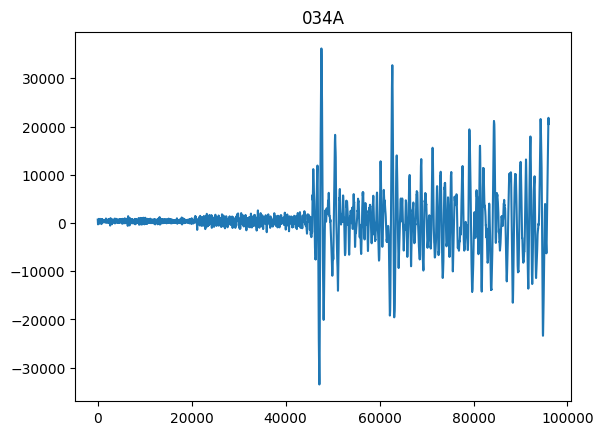

In [7]:
import matplotlib.pyplot as plt
# this is a MongoDB incantation that retrieves the first document found in the index we built above
doc = db.wf_miniseed.find_one()
# MsPASS abstraction of reading
d = db.read_data(doc,collection='wf_miniseed')
plt.plot(d.data)
plt.title(doc['sta'])
plt.show()

The next box illustrate another common need;  make a plot of data grouped by event.  First, we do a typical test to verify what we might expect to get with a database query:

In [8]:
query={'dfile' : 'Event_1.msd','chan' : 'BHZ'}
n=db.wf_miniseed.count_documents(query)
print("Total number of BHZ channels for this event=",n)

Total number of BHZ channels for this event= 444


Plotting 444 signals like that in a small frame would pretty much create a black plot frame.  Hence, the example below uses the `limit` method of the `find` operator in MongoDB to limit the result to only the first 10 "documents".   In the box below that is passed to the MsPASS `read_data` method which the reader takes as a signal to return an "ensemble" (gather in seismic reflection jargon) containing the first 10 channels of data constructed from the documents received from the database server through the "cursor".  (see sources noted above on MongoDB for more on these concepts).   This example also runs a scale function (usually necessary) to make the plot something between tne end members of 10 horizontal lines and all black.   

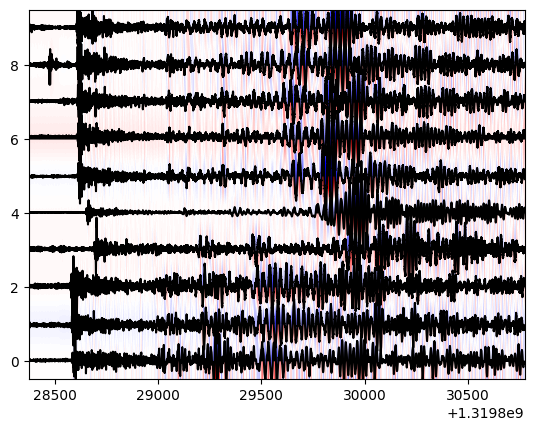

In [9]:
from mspasspy.graphics import SeismicPlotter
from mspasspy.algorithms.window import scale
plotter = SeismicPlotter()
cursor = db.wf_miniseed.find(query).limit(10)
ensemble = db.read_data(cursor,collection='wf_miniseed')
ensemble = scale(ensemble,method='rms',level=0.2)
plotter.plot(ensemble)
plt.show()

## Metadata and MongoDB 
The problem we have a the moment is our data set lacks basic information required to do almost anything beyond crude QC plots like above.   As noted earlier when we ran the function above called `index_mseed_file`, we wrote a set of "documents" to what MongoDB calls a "collection".  In our case the "collection" is the thing we chose to call "wf_miniseed".   We saw there were 26247 "documents" in "wf_miniseed".  Each of those documents can be used to construct a datum, which in MsPASS is called a `TimeSeries`, that is one waveform segment plus some auxiliary data.   In MsPASS we call that "auxiliary data" [Metadata](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.utility.Metadata), but for SAC Users Metadata acts like an open-ended header.   For those familiar with obspy the MsPASS [Metadata](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.utility.Metadata) container is used similarly to the "stats" attribute of the obspy [Trace](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.html)  object.   All these uses are conceptually identical, but access the data through a different API.   The generic concept is a key-value pair where the key is word that gives a hint of what the value part of pair defines.   A python dictionary is one of many examples in modern computing to provide an api for the generic concept of key-value pairs.   Other common names are [associative array](https://en.wikipedia.org/wiki/Associative_array)  and [map container](https://cplusplus.com/reference/map/map/).  The point is that the thing MongoDB calls a "document" is its internal version of a python dictionary.   The pymongo API translates "documents" into python dictionaries.   For reason explained [here](http://www.mspass.org/user_manual/data_object_design_concepts.html) in MsPASS we chose to do yet another translation to a special implementation we called [Metadata](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.utility.Metadata) that is an integral part of all MsPASS data objects. 

That is no doubt very confusing, but we make the point here because as a user you will need to understand how a MongoDB "document" relates to a seismic data object.   To see that, let's look at one from wf_miniseed.  We'll first define a little python function to do a "pretty print", that will make our output more readable.  Then we use a MongoDB incantation we will learn more about in our next class to fetch the first document in the collection.

In [10]:
from bson import json_util
def pretty_print(doc,indent=2):
    print(json_util.dumps(doc,indent=indent))

doc = db.wf_miniseed.find_one()
print("Content of first document in wf_miniseed collection")
pretty_print(doc)

Content of first document in wf_miniseed collection
{
  "_id": {
    "$oid": "666d53c640282871ba98e64a"
  },
  "sta": "034A",
  "net": "TA",
  "chan": "BHE",
  "sampling_rate": 40.0,
  "delta": 0.025,
  "starttime": 1299639019.000001,
  "last_packet_time": 1299641348.450001,
  "foff": 0,
  "nbytes": 86016,
  "npts": 96000,
  "endtime": 1299641418.9750009,
  "storage_mode": "file",
  "format": "mseed",
  "dir": "/home/wf",
  "dfile": "Event_16.msd",
  "time_standard": "UTC"
}


Key things to note about that output are:
1.  There is no sample data in this document.   It is only an index entry to a file.   In particular, the file name the combination of the two values associated with "dir" and "dfile".  i.e. the file name is "/home/wf/Event_12.msd".   The actual sample data are obtained by cracking the miniseed format data file start at byte zero (defined by "foff" value of 0), reading 90112 bytes (the value associated with "nbytes"), and translating the compressed packets to a standard floating point vector of data of length defined by "npts" (96000).
2.  The wf_miniseed document content is minimal.  In fact, it is simply all that can be gleaned from the raw data file.   It contains the seed channel code keys, start time data, and the sample interval.   All other quantities are index entries needed as described above to tell the reader how to crack the data file to get that particular waveform segment.

The last point is important as it shows why we aren't done yet at all if we want to do anything with these data.   We need additional information (Metadata) to know basic things like where on earth station 034A is, what the orientation of the channel is, and basic response data to know how to convert raw digital data to ground motion.   The next section describes the MsPASS way to do that using the obspy web service client similar to that we used near the top of this notebook.

### In class exercise 1:
Go to the Homework1 tab you should already have open.   Complete question 2 there.  In 10 minutes we will reconvene and continue with the rest or this notebook.  We reiterate will be submitting the Homework1 notebook for us to evaluate your progress before the next class period.  

## Station/channel Metadata
The example wf_miniseed document above shows we currently lack basic information about the seismic instrument that recorded each waveform segment defined in the wf_miniseed index.  The MsPASS User's Manual notes repeatedly that MsPASS can be thought of as an extension of obspy as obspy is bundled with the MsPASS container and conda package.  Station metadata is a case in point as MsPASS can exploit the existing functionality of obspy to obtain station metadata from FDSN data centers via web services. 

For this tutorial defining what seismic stations we want to retrieve is fairly simple;  the data set was built from only Earthscope TA stations and includes data only from calendar year 2011.   This next code block uses the obspy web service client to retieve station data from 2010 through the end of 2013 for all TA stations.

In [11]:
ts=UTCDateTime('2010-01-01T00:00:00.0')
starttime=ts
te=UTCDateTime('2013-01-01T00:00:00.0')
inv=client.get_stations(network='TA',starttime=starttime,endtime=endtime,
                        format='xml',channel='BH?',level='response')
net=inv.networks
x=net[0]
sta=x.stations
print("Number of stations retrieved=",len(sta))

Number of stations retrieved= 855


The symbol "inv" now contains an instance of what in obspy is called an "Inventory" object.  The common use with obspy is would be save the contents of "inv" in a file that could be read as needed.   Because MsPASS has an integrated MongoDB database normal practice should be to save these data to MongoDB.   We have created a special "method" of the MsPASS Database class called [save_inventory](http://www.mspass.org/python_api/mspasspy.db.html#mspasspy.db.database.Database.save_inventory).   With an instance of Database in memory, which here is the symbold "db", usage is simple:

In [12]:
ret=db.save_inventory(inv)
print('save_inventory returned value=',ret)

Database.save_inventory processing summary:
Number of site records processed= 857
number of site records saved= 857
number of channel records processed= 2796
number of channel records saved= 2784
save_inventory returned value= (857, 2784, 857, 2796)


Notice the return is a report summary of what was saved to the MongoDB database.   The report refers to "channel" and "site" records.  The easiest way to see the difference is to compare the content.  Here we extract and print the first document from each collection.  Below we explain the content and use that to explain why we create two different collections.

In [13]:
doc=db.site.find_one()
print("First record of site collection")
pretty_print(doc)

First record of site collection
{
  "_id": {
    "$oid": "666d5452f63ce193f69019c4"
  },
  "loc": "",
  "net": "TA",
  "sta": "034A",
  "lat": 27.064699,
  "lon": -98.683296,
  "coords": [
    -98.683296,
    27.064699
  ],
  "location": {
    "type": "Point",
    "coordinates": [
      -98.683296,
      27.064699
    ]
  },
  "elev": 0.155,
  "edepth": 0.0,
  "starttime": 1262908800.0,
  "endtime": 1321574399.0,
  "site_id": {
    "$oid": "666d5452f63ce193f69019c4"
  }
}


In [14]:
doc=db.channel.find_one()
print("First record of channel collection")
pretty_print(doc)

First record of channel collection
{
  "_id": {
    "$oid": "666d5452f63ce193f69019c4"
  },
  "loc": "",
  "net": "TA",
  "sta": "034A",
  "lat": 27.064699,
  "lon": -98.683296,
  "coords": [
    -98.683296,
    27.064699
  ],
  "location": {
    "type": "Point",
    "coordinates": [
      -98.683296,
      27.064699
    ]
  },
  "elev": 0.155,
  "edepth": 0.0,
  "starttime": 1262908800.0,
  "endtime": 1321549500.0,
  "chan": "BHE",
  "vang": 90.0,
  "hang": 89.1,
  "serialized_channel_data": {
    "$binary": {
      "base64": "gASV2RUAAAAAAACMHG9ic3B5LmNvcmUuaW52ZW50b3J5LmNoYW5uZWyUjAdDaGFubmVslJOUKYGUfZQojA5fbG9jYXRpb25fY29kZZSMAJSMCV9sYXRpdHVkZZSMGW9ic3B5LmNvcmUuaW52ZW50b3J5LnV0aWyUjAhMYXRpdHVkZZSTlEdAOxCQHRkVe4WUgZR9lCiMBWRhdHVtlE6MEWxvd2VyX3VuY2VydGFpbnR5lE6MEXVwcGVyX3VuY2VydGFpbnR5lE6MEm1lYXN1cmVtZW50X21ldGhvZJROdWKMCl9sb25naXR1ZGWUaAiMCUxvbmdpdHVkZZSTlEfAWKu7HyVfNYWUgZR9lChoDk5oD05oEE5oEU51YowKX2VsZXZhdGlvbpRoCIwIRGlzdGFuY2WUk5RHQGNgAAAAAACFlIGUfZQoaA9OaBBOaBFOjAVfdW5pdJROdWKMBl

If you compare that data you will see that all the site collection keys are also present in the channel collection.  Channel includes the following not found in site:
1.  The component orientation data defined with the two attributes "hang" and "vang".
2.  The SEED station code "chan", which is this case is "BHE"
3.  The special attribute "serialized_channel_data".   It contains the detailed response data for that channel stored in the python class [Channel](https://docs.obspy.org/archive/stable/packages/autogen/obspy.core.inventory.channel.Channel.html).   It is "serialized" with the standard python utility pickle and can be restored easily with pickie.   Given the importance of response data it is useful to show explicitly how to do that:

In [15]:
import pickle
resp = pickle.loads(doc["serialized_channel_data"])
print("The type of the object deserialized with pickle.loads is: ",type(resp))
print("Content returned by print applied to the object")
print(resp)

The type of the object deserialized with pickle.loads is:  <class 'obspy.core.inventory.channel.Channel'>
Content returned by print applied to the object
Channel 'BHE', Location '' 
	Time range: 2010-01-08T00:00:00.000000Z - 2011-11-17T17:05:00.000000Z
	Latitude: 27.0647, Longitude: -98.6833, Elevation: 155.0 m, Local Depth: 0.0 m
	Azimuth: 89.10 degrees from north, clockwise
	Dip: 0.00 degrees down from horizontal
	Channel types: GEOPHYSICAL
	Sampling Rate: 40.00 Hz
	Sensor (Description): None (Guralp CMG3T/Quanterra 330 Linear Phase Composite)
	Response information available


The point is that the content of "serialized_channel_data" is an image of the StationXML record for, in this case, channel "BHZ" associated with the TA station "O34A".   An Inventory, as stated in the obspy documentation, is "in essence just a container for one or more networks".  In MsPASS we organize this same data with MonogDB rather than depending on a file.   We split data common to all channels of a station into the "site" collection and store the more detailed an voluminuous channel data to the "channel" collection.  That is useful because for many contexts the data contained in "channel" is at best misleading.   The most common example, which we will discuss shortly, is data bundled into a three-component bundle we call a [Seismogram](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.seismic.Seismogram);  when data are bundled into a three-component set the orientation data, for example, is meaningless and is a fundamental part of the definition of the data and not "Metadata".   

With those details the point of where we are right now is that we have a complete set of data stored in "site" and "channel",  The next issue is linking these data to our waveform data.   The obspy way to solve this issue would be to use the indexing in the Inventory object to associate waveforms with station metadata on the fly.   In MsPASS we use a more generic database approach that MongoDB calls "normalization".   

## Normalization
### Concepts
For those familiar with relational database systems, what MongoDB calls "Normalization" is conceptually similar to a relational database join.   The distinction is:
1.  Normalization is not automated in MongoDB the way a join is in a relational database (JOIN is a standard keyword in SQL). 
2.  In MongoDB normalization is best limited to many-to-one joins where the information to be joined/normalized is small compared to the target.   In our case the `target` is the content of a "waveform" collection, which means documents that contain key-value pairs that can be used to construct a valid seismic data object.  

Normalization of collection A with the content of collection B requires two step:  (1) apply a matching algorithm that defines a (normally unique) match between collections A and B, and (2) merge all or part of the content of B with A.  This section provides an example for the workflow considered in this workshop.   For more information on the topic see the [MsPASS User Manual section on normalization](http://www.mspass.org/user_manual/normalization.html).  
## Cross-referencing Ids
The most reliable way with MongoDB to accomplish normalization is to use an id as a cross-reference.  Integer id values are ubiquituous in relational databases and are the reason things like student id numbers exist.  MongoDB uses a special form of unique identifier they call an ObjectId, but the concept is identical to integers in relational database schemas;  the id is used as a tag to guarantee uniqueness.  I will illustrate how we do that in MsPASS with station metadata we will link to each wf_miniseed record we created above.

Because of the importance of miniseed data to seismology today, MsPASS has a special cross-referencing function for handling miniseed.  The box below applies this function to create the corss-referencing ids.  First, let's run this algorithm and then we will show what it does. 

In [16]:
from mspasspy.db.normalize import normalize_mseed
ret = normalize_mseed(db)
print("Number of documents processed in wf_miniseed=",ret[0])
print("Number of documents updated with channel cross reference id=",ret[1])
print("Number of documents updated with site cross reference id=",ret[2])

Number of documents processed in wf_miniseed= 26247
Number of documents updated with channel cross reference id= 26247
Number of documents updated with site cross reference id= 26247


Let's look at the same wf_miniseed record we examined earlier and see how it has changed:

In [17]:
doc=db.wf_miniseed.find_one()
pretty_print(doc)

{
  "_id": {
    "$oid": "666d53c640282871ba98e64a"
  },
  "sta": "034A",
  "net": "TA",
  "chan": "BHE",
  "sampling_rate": 40.0,
  "delta": 0.025,
  "starttime": 1299639019.000001,
  "last_packet_time": 1299641348.450001,
  "foff": 0,
  "nbytes": 86016,
  "npts": 96000,
  "endtime": 1299641418.9750009,
  "storage_mode": "file",
  "format": "mseed",
  "dir": "/home/wf",
  "dfile": "Event_16.msd",
  "time_standard": "UTC",
  "channel_endtime": 1321549500.0,
  "channel_hang": 89.1,
  "channel_id": {
    "$oid": "666d5452f63ce193f69019c4"
  },
  "channel_starttime": 1262908800.0,
  "channel_vang": 90.0,
  "site_endtime": 1321574399.0,
  "site_id": {
    "$oid": "666d5452f63ce193f69019c4"
  },
  "site_starttime": 1262908800.0
}


Comparison with above shows there are several keys added with that begin with "channel_".  The main one of interest is the one called "channel_id".   It is used for "normalization" as a cross-reference id.  The following incantation is a version of what needs to be done to link records in channel to a wf_miniseed entry.  Note this block of code is for illustration only to help you understand what is done.  The MsPASS methods that would do this on the fly use a variant of this block of code.  

In [18]:
query={"_id" : doc["channel_id"]}
chan_doc = db.channel.find_one(query)
print("wf_miniseed channel_id value=",doc["channel_id"])
print("id value returned by query")
print(chan_doc['_id'])
print("Full channel document content:")
pretty_print(chan_doc)

wf_miniseed channel_id value= 666d5452f63ce193f69019c4
id value returned by query
666d5452f63ce193f69019c4
Full channel document content:
{
  "_id": {
    "$oid": "666d5452f63ce193f69019c4"
  },
  "loc": "",
  "net": "TA",
  "sta": "034A",
  "lat": 27.064699,
  "lon": -98.683296,
  "coords": [
    -98.683296,
    27.064699
  ],
  "location": {
    "type": "Point",
    "coordinates": [
      -98.683296,
      27.064699
    ]
  },
  "elev": 0.155,
  "edepth": 0.0,
  "starttime": 1262908800.0,
  "endtime": 1321549500.0,
  "chan": "BHE",
  "vang": 90.0,
  "hang": 89.1,
  "serialized_channel_data": {
    "$binary": {
      "base64": "gASV2RUAAAAAAACMHG9ic3B5LmNvcmUuaW52ZW50b3J5LmNoYW5uZWyUjAdDaGFubmVslJOUKYGUfZQojA5fbG9jYXRpb25fY29kZZSMAJSMCV9sYXRpdHVkZZSMGW9ic3B5LmNvcmUuaW52ZW50b3J5LnV0aWyUjAhMYXRpdHVkZZSTlEdAOxCQHRkVe4WUgZR9lCiMBWRhdHVtlE6MEWxvd2VyX3VuY2VydGFpbnR5lE6MEXVwcGVyX3VuY2VydGFpbnR5lE6MEm1lYXN1cmVtZW50X21ldGhvZJROdWKMCl9sb25naXR1ZGWUaAiMCUxvbmdpdHVkZZSTlEfAWKu7HyVfNYWUgZR9lChoDk5

The point being that the id provides a way to do a unique match between documents in wf_miniseed and the channel collection.  Why that is useful is that we can now load such data automatically during a read operation.   The following example reads the first two waveforms from wf_miniseed and loads the channel metadata on the fly. The print statements display only the content of the Metadata container of each of the two data objects we retreive.

In [19]:
from mspasspy.db.normalize import ObjectIdMatcher
chan_matcher = ObjectIdMatcher(db)
cursor=db.wf_miniseed.find({}).limit(2)
for doc in cursor:
    print("document retrieved from MongoDB:")
    pretty_print(doc)
    d= db.read_data(doc,collection="wf_miniseed",normalize=[chan_matcher])
    d_doc = dict(d)
    print("Metadata content stored in TimeSeries object constructed by read_data")
    pretty_print(d_doc)

document retrieved from MongoDB:
{
  "_id": {
    "$oid": "666d53c640282871ba98e64a"
  },
  "sta": "034A",
  "net": "TA",
  "chan": "BHE",
  "sampling_rate": 40.0,
  "delta": 0.025,
  "starttime": 1299639019.000001,
  "last_packet_time": 1299641348.450001,
  "foff": 0,
  "nbytes": 86016,
  "npts": 96000,
  "endtime": 1299641418.9750009,
  "storage_mode": "file",
  "format": "mseed",
  "dir": "/home/wf",
  "dfile": "Event_16.msd",
  "time_standard": "UTC",
  "channel_endtime": 1321549500.0,
  "channel_hang": 89.1,
  "channel_id": {
    "$oid": "666d5452f63ce193f69019c4"
  },
  "channel_starttime": 1262908800.0,
  "channel_vang": 90.0,
  "site_endtime": 1321574399.0,
  "site_id": {
    "$oid": "666d5452f63ce193f69019c4"
  },
  "site_starttime": 1262908800.0
}
Metadata content stored in TimeSeries object constructed by read_data
{
  "channel_endtime": 1321549500.0,
  "site_id": {
    "$oid": "666d5452f63ce193f69019c4"
  },
  "nbytes": 86016,
  "net": "TA",
  "foff": 0,
  "sampling_rate": 

Comparison of the before and after records should help you see the attributes loaded with the "channel_" prefix.  That is a type example of normalization during construction of data objects used in MsPASS.  For more on this concept see [this section](http://www.mspass.org/user_manual/normalization.html) of the User Manual.  

### Source normalization
An seismology workflow based on seismic phases requires not only station Metadata but at least the coordinate information about all seismic sources.  The data set we are working with here is a case in point:  the first thing we did in this notebook was download a set of (20) earthquake source records from FDSN.  Thos source records, in fact, were used to drive the original data download procedure that produced the miniseed files we have been working with.   

Source normalization can be a very challenging problem for reasons that are beyond the scope of this introductory course.  Our example has a particularly simple association problem.   The reason is that the data were downloaded using obspy's web service client.   The specific incanation used was the following:
```
strm=client.get_waveforms(
            starttime=UTCDateTime(stime),
            endtime=UTCDateTime(etime),
            network='TA',
            channel='BH?',
            location='*'
        )
```
where "stime" and "etime" were computed from each source origin time as:
```
    stime=origin_time+start_offset
    etime=origin_time+end_offset
```
with
```
start_offset=300.0
end_offset=45*60.0
```
That is, all waveforms have start times approximately 400 s after the origin time of each event in the set of events we stored in the "source" collection.   Because this appproach to cutting waveforms from the archive is very common we created a special normalization function to match data created that way (i.e. fixed offset from an origin time) called [OriginTimeMatcher](http://www.mspass.org/python_api/mspasspy.db.html#mspasspy.db.normalize.OriginTimeMatcher).  To see how that python class can be used let's first create an instance of the class keying on the 400 s offset from the origin time used for these data:

In [20]:
from mspasspy.db.normalize import OriginTimeMatcher
# warning:  there are versions of this data where this may need to be 400 instead of 300
source_matcher = OriginTimeMatcher(db,t0offset=300.0,tolerance=100.0)

OriginTimeMatcher is an example of a generic set of "matcher" objects used to efficiently handle matching source and receiver metadata to waveforms.  Examples we will use below to utilize this object to match records from the source collection to each waveform.   They actually do that internally through the "find" method whose use is illustrated here:

In [21]:
doc=db.wf_miniseed.find_one()
d=db.read_data(doc,collection='wf_miniseed')
md,elog = source_matcher.find(d)
print(md)

[Metadata({'source_depth': 26.200000, 'source_id': ObjectId('666d53c3f63ce193f69019c0'), 'source_lat': 38.440700, 'source_lon': 142.980300, 'source_magnitude': 7.300000, 'source_time': 1299638719.590000})]


To show you the reader handles this, consider this minor variant of the code box above.   There are two you should note:
1.  To reduce output in this case we only show one datum.
2.  we add the instance of [OriginTimeMatcher](http://www.mspass.org/python_api/mspasspy.db.html#mspasspy.db.normalize.OriginTimeMatcher), which we assigned to the symbol "source_matcher", to the list passed via the normalize argument.


In [22]:
doc=db.wf_miniseed.find_one()
print("document retrieved from MongoDB:")
pretty_print(doc)
d= db.read_data(doc,collection="wf_miniseed",normalize=[chan_matcher,source_matcher])
d_doc = dict(d)
print("Metadata content stored in TimeSeries object constructed by read_data")
pretty_print(d_doc)

document retrieved from MongoDB:
{
  "_id": {
    "$oid": "666d53c640282871ba98e64a"
  },
  "sta": "034A",
  "net": "TA",
  "chan": "BHE",
  "sampling_rate": 40.0,
  "delta": 0.025,
  "starttime": 1299639019.000001,
  "last_packet_time": 1299641348.450001,
  "foff": 0,
  "nbytes": 86016,
  "npts": 96000,
  "endtime": 1299641418.9750009,
  "storage_mode": "file",
  "format": "mseed",
  "dir": "/home/wf",
  "dfile": "Event_16.msd",
  "time_standard": "UTC",
  "channel_endtime": 1321549500.0,
  "channel_hang": 89.1,
  "channel_id": {
    "$oid": "666d5452f63ce193f69019c4"
  },
  "channel_starttime": 1262908800.0,
  "channel_vang": 90.0,
  "site_endtime": 1321574399.0,
  "site_id": {
    "$oid": "666d5452f63ce193f69019c4"
  },
  "site_starttime": 1262908800.0
}
Metadata content stored in TimeSeries object constructed by read_data
{
  "channel_endtime": 1321549500.0,
  "site_id": {
    "$oid": "666d5452f63ce193f69019c4"
  },
  "nbytes": 86016,
  "net": "TA",
  "foff": 0,
  "sampling_rate": 

You should note that the key difference is that now the datum, d, has data from both the channel collection (the ones with the "channel_" prefix like "channel_lat", and the source collection (the ones with the "source_" prefix like "source_lat").  

### In class exercise 2:
Go to the Homework1 tab and complete the questions tagged with the title above.  

## Waveform Processing
### Perspective Checkpoint
The primary purpose of MsPASS is a modern tool to efficiently handle the massive volumes of seismology data that exist today.   All the above should be viewed as the process of assembling a data set and building a research-ready data set.  In our experience with MsPASS or any framework that has four elements that the above illustrates for MsPASS:
1.  Assemble the waveform segments that are to be used as input for your project.   Our example uses miniseed files downloaded previously from FDSN data centers.  There are many other ways one could obtain waveform data for a project but today the FDSN model is the most common and universally applicable.
2.  Assemble the station metadata that contain fundamental data about what seismic station and instrumentation that describes each channel of data in the data set.  We used the FDSN model, but that is far from unique.   The model used, for example, in seismic reflection processing is drastically different.   The overall goal, however, is the same;  defining a set of attributes for each channel of data required by your workflow.
3.  Most, but not all, workflows also require linking each waveform to attributes of the seismic source that created the observed signal(s).   (A notable exception today is noise-correlation or any study based on noise where there is no "source" associated with each datum.)
4.  Quallity control to expunge a long list of issues that can exist in any real data set.   In this example we have largely ignored this important issue.  All we did was a quick look at a few waveforms to verify things were working.   Real work requires care in filtering out junk and correcting any metadata errors that often crop up when dealing with large numbers of waveforms (e.g. you can't even find any information about a particular waveform defined by miniseed net:sta:chan:loc key and a particular time interval.)   We omitted that from this tutorial because:  (a) the details would quickly bog down the exercise and confuse you more than help you and (b) there are too many potential issues to address that may or may not ever be relevant to your work - good QC is just good science practice that is a separate topic outside the scope of this class.

With that background we now have a base starting point with these elements:
1.  A clean index to the miniseed files stored MonogDB in the "wf_miniseed" collection.
2.  A complete set of station/channel metadata stored in the MonogDB collections we call "channel" and "site".   At the moment only "channel" is relevant, but shortly we will produce three component bundles of data where the "site" collection is the preferred station metadata collection.
3.  A complete collection of source metadata we know resolves with each waveform in the data set.

The next step is demonstate you would actually do the kind of low-level processing MsPASS was designed to do.   For this session of the course we will focus only on "serial processing", which means the kind of python code you would use to process data on a desktop.   We have found that all workflows are best constructed and debugged in this mode whether running on a cluster or a desktop.   For large data sets the goal of the serial process is to get timing data running on a small subset of the data  that can allows a realistic projection of how long the same steps would require on a cluster with N workers.  This data set is not huge so the serial processing is feasible - the code below takes around 15 minutes for modern desktop.   On day 3 of this course we will discuss how to parallelize the algorithm below and how to predict the time to scale it up to a larger data set.  

### Serial Workflow
The python code below illustrates a typical processing sequence driven by seismic "phase" information.   That is, the algorithm is driven by seismic phase times where the objective is to cut out a waveform segment that defines the signal of that "phase" and do something with it.   The example here aims to cut out time windows keyed on the P wave arrival time.  The algorithm also need to do two simple, common signal processing steps to create a set of clean waveforms:
1.  A detrend operation is essential with data from any modern, broadband instrument because all such data have a significant DC offset.  If not corrected the following two steps would create large transients that are pure artifacts.
2.  Do a light fliter to a passband of generic interest.   Since this data set contains only teleseismic waveforms any signal over 2 Hz is more than likely pure noise.  Hence we do a lowpass filter with a corner at 2 Hz.

Each of the above is accomplished below with one line of code.   Specifically, look below and you will see where that is done with the following 3 lines of python code:
```
    d = detrend(d,type="constant")
    d = filter(d,'lowpass',freq=2.0,zerophase=False)
```
Everything else below is a set of incantations used to complete travel times, set some auxiliary Metadata fields that define arrival times and other Metadata we will need later, and then using the posted times to window the data.  We could have implemented the code to do that within the processing loop in the second code box below.   However, for reasons we will see in the session on parallel processing (see also [this section of the User Manual](http://www.mspass.org/user_manual/parallel_processing.html) it is useful to encapsulate specific steps into python functions.   The following code box only defines two functions.  See the docstring for each function to see what the function is designed to do.  (Note that also illustrates common practice all students of this course should take to heart - all functions should have at least a bare-bones docstring describing what is is supposed to do and what the arguments are.)

In [23]:
from mspasspy.algorithms.window import WindowData
from mspasspy.algorithms.signals import detrend
from mspasspy.algorithms.basic import ator
from mspasspy.ccore.algorithms.basic import TimeWindow
from mspasspy.ccore.utility import ErrorSeverity
from mspasspy.db.normalize import (normalize,
                                   ObjectIdMatcher,
                                   OriginTimeMatcher)
from mspasspy.algorithms.window import WindowData
from mspasspy.algorithms.resample import (ScipyResampler,
                                          ScipyDecimator,
                                          resample,
                                         )
from obspy.geodetics import gps2dist_azimuth,kilometers2degrees
from obspy.taup import TauPyModel
import time

def set_PStime(d,Ptimekey="Ptime",Stimekey="Stime",model=None):
    """
    Function to calculate P and S wave arrival time and set times 
    as the header (Metadata) fields defined by Ptimekey and Stimekey.
    Tries to handle some complexities of the travel time calculator 
    returns when one or both P and S aren't calculatable.  That is 
    the norm in or at the edge of the core shadow.  
    
    :param d:  input TimeSeries datum.  Assumes datum's Metadata 
      contains stock source and channel attributes.  
    :param Ptimekey:  key used to define the header attribute that 
      will contain the computed P time.  Default "Ptime".
    :param model:  instance of obspy TauPyModel travel time engine. 
      Default is None.   That mode is slow as an new engine will be
      constructed on each call to the function.  Normal use should 
      pass an instance for greater efficiency.  
    """
    if d.live:
        if model is None:
            model = TauPyModel(model="iasp91") 
        # extract required source attributes
        srclat=d["source_lat"]
        srclon=d["source_lon"]
        srcz=d["source_depth"]
        srct=d["source_time"] 
        # extract required channel attributes
        stalat=d["channel_lat"]
        stalon=d["channel_lon"]
        staelev=d["channel_elev"]
        # set up and run travel time calculator
        georesult=gps2dist_azimuth(srclat,srclon,stalat,stalon)
        # obspy's function we just called returns distance in m in element 0 of a tuple
        # their travel time calculator it is degrees so we need this conversion
        dist=kilometers2degrees(georesult[0]/1000.0)
        arrivals=model.get_travel_times(source_depth_in_km=srcz,
                                            distance_in_degree=dist,
                                            phase_list=['P','S'])
        # always post this for as it is not cheap to compute
        # WARNING:  don't use common abbrevation delta - collides with data dt
        d['epicentral_distance']=dist
        # these are CSS3.0 shorthands s - station e - event
        esaz = georesult[1]
        seaz = georesult[2]
        # css3.0 names esax = event to source azimuth; seaz = source to event azimuth
        d['esaz']=esaz
        d['seaz']=seaz
        # get_travel_times returns an empty list if a P time cannot be 
        # calculated.  We trap that condition and kill the output 
        # with an error message
        if len(arrivals)==2:
            Ptime=srct+arrivals[0].time
            rayp = arrivals[0].ray_param
            Stime=srct+arrivals[1].time
            rayp_S = arrivals[1].ray_param
            d.put(Ptimekey,Ptime)
            d.put(Stimekey,Stime)
            # These keys are not passed as arguments but could be - a choice
            # Ray parameter is needed for free surface transformation operator
            # note tau p calculator in obspy returns p=R sin(theta)/V_0
            d.put("rayp_P",rayp)
            d.put("rayp_S",rayp_S)
        elif len(arrivals)==1:
            if arrivals[0].name == 'P':
                Ptime=srct+arrivals[0].time
                rayp = arrivals[0].ray_param
                d.put(Ptimekey,Ptime)
                d.put("rayp_P",rayp)
            else:
                # Not sure we can assume name is S
                if arrivals[0].name == 'S':
                    Stime=srct+arrivals[0].time
                    rayp_S = arrivals[0].ray_param
                    d.put(Stimekey,Stime)
                    d.put("rayp_S",rayp_S)
                else:
                    message = "Unexpected single phase name returned by taup calculator\n"
                    message += "Expected phase name S but got " + arrivals[0].name
                    d.elog.log_error("set_PStime",
                                     message,
                                     ErrorSeverity.Invalid)
                    d.kill()
                
    # Note python indents mean if an ensemble is marked dead this function just silenetly returns 
    # what it received doing nothing - correct mspass model
    return d
def cut_Pwindow(d,stime=-100.0,etime=500.0):
    """
    Window datum relative to P time window.  Time
    interval extracted is Ptime+stime to Ptime+etime.
    Uses ator,rtoa feature of MsPASS.
    """
    if d.live:
        if "Ptime" in d:
            ptime = d["Ptime"]
            d.ator(ptime)
            d = WindowData(d,stime,etime)
            d.rtoa()
    return d
   

For each of the functions we just defined it is worth noting:
1.  *set_PStime* is a pure Metadata function.  It extracts data from the the datum, d, needed to compute times, computes the times geometric data and times, and then posts a set of attributes to datum before it is returned.  Specifically, it normally posts these:  "epicentral_distance","seaz","esaz","Ptime","rayp_P","Stime","rayp_S".   (Note logic to not post attributes that cannot be calculated - that is not treated as an exception here.)
2.  *cut_Pwindow* is a wrapper for the generic algorithm [WindowData](http://www.mspass.org/python_api/mspasspy.algorithms.html#mspasspy.algorithms.window.WindowData).   An oddity you should understand is the concepts behind the calls to the `ator` and `rtoa` methods of the `TimeSeries` object that the symbol "d" is expected to define.  The idea of "Relative" versus "UTC" time is a novel, but not difficult concept, used in MsPASS.  The basic concepts are describe in [this section of the User Manual](http://www.mspass.org/user_manual/time_standard_constraints.html).

With that understanding of those two function, here is the python code that does the processing discussed above.   Note three things about this code:
1.  The "serial" processing is defined by a data-driven loop using a MongoDB "cursor" object.   You will learn more about this concept in the next session of this class.  For now understand that the incantations used here define a loop over all waveforms indexed in wf_miniseed.
2.  The sequence in the loop defines the most commmon algorithm in low-level data processing like this:   read data, do the processing steps, and save results.
3.  All the processing steps are defined by functions of the form `d = function(d,args)` where arg0 of the function is the datum to be processed.  Note all functions return the modified copied of d.   That is not required practice in python programming, but is what you need to do in MsPASS to simplify the process we will do later to convert this code to a parallel form.  If you want to read up on why that is so before session 3, see [this section of the User Manual](http://www.mspass.org/user_manual/parallel_processing.html)

In [24]:
from obspy.taup import TauPyModel
from mspasspy.algorithms.signals import filter,detrend

ttmodel = TauPyModel(model="iasp91")
stime=-100.0
etime=500.0    

t0 = time.time()
nlive=0
ndead=0
cursor=db.wf_miniseed.find({})
for doc in cursor:
    # the normalize matchers in this read were defined in the normalize section of this 
    # notebook.  Could cause problems if this box is run out of order
    d = db.read_data(doc,collection='wf_miniseed',normalize=[chan_matcher,source_matcher])
    d = detrend(d,type="constant")
    d = filter(d,'lowpass',freq=2.0,zerophase=False)
    # this function will run faster if passed an instance the TauP calculator (ttmodel)
    # If left as the default an instance is instantiated on each call to the function which is very inefficient.
    d = set_PStime(d,model=ttmodel)
    d = cut_Pwindow(d,stime,etime)
    if d.live:
        nlive += 1
    else:
        ndead += 1
    db.save_data(d,storage_mode='file',dir='./wf_TimeSeries',data_tag='serial_preprocessed')
t=time.time()    
print("Total processing time=",t-t0)
print("Number of live data saved=",nlive)
print("number of data killed=",ndead)

Total processing time= 451.4164764881134
Number of live data saved= 26178
number of data killed= 69


/opt/conda/lib/python3.10/site-packages/obspy/io/mseed/headers.py:805: InternalMSEEDWarning: readMSEEDBuffer(): Unexpected end of file when parsing record starting at offset 69632. The rest of the file will not be read.
  warnings.warn(_w, InternalMSEEDWarning)


# MsPASS Data Objects
Users of MsPASS need to understand that the framework is "object oriented".   In modern jargon an "object" is an instance of a data structure that is defined with the keyword "class" in python.   That is important because all the containers used to hold seismic data are "objects".   All use a full suite of object oriented programming concepts including a full collection of "methods" and "inheritance" that allows common concepts like the [Metadata](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.utility.Metadata) container to be used in all seismic data objects.  Most of that is under the hood but the key point is when you use MsPASS you should be aware of the methods that are implemented with all data objects.   More details about the design and motivation for the MsPASS data objects can be found [in this section of the User Manual](http://www.mspass.org/user_manual/data_object_design_concepts.html).  Note also the descriptions below have hyperlinks to the python bindings for objects implemented in C++.   The python documentation is currently incomplete compared to the C++ documentation we generate with a package called "doxygen".  The doxygen pages, however, are not indexed to allow direct links to a type like the python bindings.  We recommend while reading this you open a tab to [this page](http://www.mspass.org/cxx_api/mspass.html#mspass-namespace) and enter the name of each data object discussed below to find the doxygen page for that entity.   

With that background it is important to realize there are four seismic data types used in MsPASS.   Two are what we call "atomic" because they represent a single thing:
1.  The [TimeSeries](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.seismic.TimeSeries) container is used to hold single-channel data.  It is the container we have used up till now in this tutorial.  As is standard for all time series analysis the sample data is stored in a vector container under the symbol `data`.   It is important to realize that vector satisfies the "array like" definition of numpy so it can be used and manipulated like a numpy array as described in [this section](http://www.mspass.org/user_manual/numpy_scipy_interface.html) of the User Manual.   It inherits a [Metadata](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.utility.Metadata) container and a [ProcessingHistory](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.utility.ProcessingHistory) container.   It also "has a" [ErrorLogger](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.utility.ErrorLogger) attribute under the symbol `elog` used to post error messages.
2.  The [Seismogram](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.seismic.Seismogram) container is used to contain assembled three-component data groups.  It has exactly the same base methods as [TimeSeries](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.seismic.TimeSeries) by inheriting common code from [Metadata](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.utility.Metadata) and [ProcessingHistory](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.utility.ProcessingHistory) as well as a common base class called `BasicTimeSeries`, which is hidden under the python bindings.  A key difference is that the `data` attribute of [Seismogram](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.seismic.Seismogram) is a matrix instead of a vector.   Specifically, `data` is a 3X`npts` matrix where `npts` is the attribute of the object that defines the number of (three-vector) samples.  (The same symbol is used for [TimeSeries](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.seismic.TimeSeries) to define the number of scalar samples.)  The rows of the matrix are the components that were assembled to produce a particular instance of a [Seismogram](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.seismic.Seismogram) object.  As with [TimeSeries](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.seismic.TimeSeries) objects the `data` attribute of [Seismogram](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.seismic.Seismogram)  can be treated like a numpy 3X`npts` matrix.  In short, other than additional methods appropriate only to three-component data and the structure of the data container a `Seismogram` and `TimeSeries` have a common API.

The two other seismic data containers in MsPASS are "ensembles" with a common API.  We define an "ensemble" as a bundled group of objects of a common type.   Given that there are two atomic types, you can hopefully see the logic of the following two "ensemble" types defined in MsPASS:
1.  A [TimeSeriesEnsemble](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.seismic.TimeSeriesEnsemble) is a bundle of [TimeSeries](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.seismic.TimeSeries) objects.
2.  A [SeismogramEnsemble](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.seismic.SeismogramEnsemble) is a bundle of [Seismogram](http://www.mspass.org/python_api/mspasspy.ccore.html#mspasspy.ccore.seismic.Seismogram) objects.

The "bundle" for both objects is a generalized vector of the atomic data with which that container is linked.  That generalized vector is referenced by the `member` attribute of an instance of the class. All that is likely much clearer after you run the following code box.  Run it and go to the markdown box that follows:

In [25]:
# generate a MongoDB query for the first source in the source collection
srcdoc=db.source.find_one()
query={'source_id' : srcdoc['_id']}
print(db.TimeSeries.count_documents(query))
cursor=db.wf_TimeSeries.find(query).limit(10)   # limit the return to avoid a huge output that serves no purpose
ensemble=db.read_data(cursor)
print("The python type name of ensemble",type(ensemble))
# member is the vector container of objects
# we can use the python len operator just like a numpy array to get size
Nmembers = len(ensemble.member)
print("sta  first_sample_value type_member")
for i in range(Nmembers):
    d = ensemble.member[i]   # Illustrates vector subscripting of the container
    print(d['sta'],d.data[0],type(ensemble.member[i]))
# note the loop could have also been done this way:
#  for d in enemble.member:

0
The python type name of ensemble <class 'mspasspy.ccore.seismic.TimeSeriesEnsemble'>
sta  first_sample_value type_member
109C -0.11907704964666857 <class 'mspasspy.ccore.seismic.TimeSeries'>
109C -0.08909276020658323 <class 'mspasspy.ccore.seismic.TimeSeries'>
109C -0.05855662436621069 <class 'mspasspy.ccore.seismic.TimeSeries'>
121A -0.015994278912385054 <class 'mspasspy.ccore.seismic.TimeSeries'>
121A 0.060361805602953365 <class 'mspasspy.ccore.seismic.TimeSeries'>
121A -0.008505339626278823 <class 'mspasspy.ccore.seismic.TimeSeries'>
136A -0.2971319565225641 <class 'mspasspy.ccore.seismic.TimeSeries'>
136A -0.407106218164884 <class 'mspasspy.ccore.seismic.TimeSeries'>
136A -0.6445171614191527 <class 'mspasspy.ccore.seismic.TimeSeries'>
137A 0.048800582689315634 <class 'mspasspy.ccore.seismic.TimeSeries'>


Key points you shoulkd see from the above python code are:
1.  The `member` attribute acts like a vector that is subscriptable and iterable.
2.  Each component of `member` is an atomic object, which in this instance is a `TimeSeries`.   In a moment we will create a comparable container for `Seismogram`objects.
3.  Each component has a `data` attribute that is itself a (numpy like) container holding the sample data.   `data` is itself indexable, iterable, and can even utilize the numpy "colon" notation (not illustrated but described [here](http://www.mspass.org/user_manual/numpy_scipy_interface.html)).

## Creating Seismogram data from wf_TimeSeries
The last thing we will do for this session is create a database of `Seismogram` objects from the "wf_TimeSeries" collection we created above.   For the present treat this as an example that can be used to build a working data set of `Seismogram` objects from an input of `TimeSeries` data.   We use a special MsPASS function called [bundle_seed_data](http://www.mspass.org/python_api/mspasspy.algorithms.html#mspasspy.algorithms.bundle.bundle_seed_data) to do all the work.   The algorithm here is a loop over source_id values.   In each pass through the loop the reader creates a `TimeSeriesEnsemble`.  That ensemble is passed to the [bundle_seed_data](http://www.mspass.org/python_api/mspasspy.algorithms.html#mspasspy.algorithms.bundle.bundle_seed_data) function that returns a `SeismogramEnsemble` whos `member` vector has roughly 1/3 as many components at the input.   The reason, of course, is that three `TimeSeries` are required to produce one `Seismogram`.

We will examine more properties of ensembles and `Seismogram` objects in the second session of this class.

In [26]:
from mspasspy.algorithms.bundle import bundle_seed_data
from mspasspy.util.Undertaker import Undertaker

stedronsky=Undertaker(db)
srcids=db.wf_TimeSeries.distinct('source_id')
nsrc=len(srcids)
print("This run will process ",nsrc,
      " common source gathers into Seismogram objects")
for sid in srcids:
    query={'source_id' : sid,
           'data_tag' : 'serial_preprocessed'}
    nd=db.wf_TimeSeries.count_documents(query)
    print('working on ensemble with source_id=',sid)
    print('database contains ',nd,' documents == channels for this ensemble')
    cursor=db.wf_TimeSeries.find(query)
    # For this operation we only need channel metadata loaded by normalization
    # orientation data is critical (hang and vang attributes)
    ensemble = db.read_data(cursor,
                            normalize=[chan_matcher],
                           )
    print('Number of TimeSeries objects constructed for this source=',len(ensemble.member))
    ensemble=bundle_seed_data(ensemble)
    # The reader would do the following handling of dead data automatically
    # it is included here for demonstration purposes only
    # part of the lesson is handling of dead data
    print('Number of (3C) Seismogram object created from input ensemble=',len(ensemble.member))
    [living,bodies]=stedronsky.bring_out_your_dead(ensemble)
    print('number of bundled Seismogram=',len(living.member))
    print('number of killed Seismogram=',len(bodies.member))
    # bury the dead if necessary
    if len(bodies.member)>0:
        stedronsky.bury(bodies)
    db.save_data(ensemble,storage_mode='file',dir='./wf_Seismogram',collection='wf_Seismogram',data_tag='serial_preprocessed')

This run will process  20  common source gathers into Seismogram objects
working on ensemble with source_id= 666d53c3f63ce193f69019b0
database contains  1311  documents == channels for this ensemble
Number of TimeSeries objects constructed for this source= 1311
Number of (3C) Seismogram object created from input ensemble= 437
number of bundled Seismogram= 437
number of killed Seismogram= 0
working on ensemble with source_id= 666d53c3f63ce193f69019b1
database contains  1332  documents == channels for this ensemble
Number of TimeSeries objects constructed for this source= 1332
Number of (3C) Seismogram object created from input ensemble= 444
number of bundled Seismogram= 444
number of killed Seismogram= 0
working on ensemble with source_id= 666d53c3f63ce193f69019b2
database contains  1323  documents == channels for this ensemble
Number of TimeSeries objects constructed for this source= 1323
Number of (3C) Seismogram object created from input ensemble= 441
number of bundled Seismogram= 44

## Dead data
The print summary at the end of the above box list the "number of data killed".   MsPASS uses the kill concept that has been a stable of seismic reflection processing since the 1960s. More on the topic and why it is essential for handling large data sets can be found in the [this section](http://www.mspass.org/user_manual/handling_errors.html) of the MsPASS User Manual.   A novel feature of MsPASS is that the errors that caused a datum to be killed are stored in the database in a special collection with the colorful name "cemetery".   I'll close this session by briefly visiting the cemetery.

In [27]:
doc=db.cemetery.find_one()
print(json_util.dumps(doc,indent=2))

{
  "_id": {
    "$oid": "666d54cef63ce193f69080f7"
  },
  "logdata": [
    {
      "job_id": 0,
      "algorithm": "WindowData",
      "badness": "ErrorSeverity.Invalid",
      "error_message": "Data range is smaller than window range\nWindow range: -100.0,500.0  Data range:  -73.55061554908752,2326.4243844509124",
      "process_id": 204
    }
  ],
  "wf_TimeSeries_id": {
    "$oid": "666d53cb426254a3dff2abfd"
  },
  "tombstone": {
    "channel_endtime": 1463412000.0,
    "site_id": {
      "$oid": "666d5453f63ce193f6901bda"
    },
    "nbytes": 126976,
    "rayp_P": 504.26141898222767,
    "net": "TA",
    "rayp_S": 894.1638948877862,
    "foff": 38007296,
    "sampling_rate": 40.0,
    "site_endtime": 1463443199.0,
    "source_magnitude": 7.3,
    "processing": [
      "ObsPy 1.4.1: detrend(options={}::type='constant')",
      "ObsPy 1.4.1: filter(options={'freq': 2.0, 'zerophase': False}::type='lowpass')"
    ],
    "channel_vang": 90.0,
    "starttime": 1308885278.024998,
    "df

Notice a cemetery record has two main pieces:  (1) a list of error log messages accessible by the key "logdata", and (2) what MongoDB would call a "subdocument", which in python means dictionary, accessible with the key "tombstone".  The "tombstone" data is a dump of any dead datum's Metadata container.   The "logdata" list is a useful way to sort out why data were killed.   The last code box illustrates one way to do this by just dumping the content of the first 10 cemetery documents.

In [28]:
cursor = db.cemetery.find({}).limit(10)
for doc in cursor:
    errlist=doc["logdata"]
    for err in errlist:
        print(err)

{'job_id': 0, 'algorithm': 'WindowData', 'badness': 'ErrorSeverity.Invalid', 'error_message': 'Data range is smaller than window range\nWindow range: -100.0,500.0  Data range:  -73.55061554908752,2326.4243844509124', 'process_id': 204}
{'job_id': 0, 'algorithm': 'WindowData', 'badness': 'ErrorSeverity.Invalid', 'error_message': 'Data range is smaller than window range\nWindow range: -100.0,500.0  Data range:  -73.55061554908752,2326.4243844509124', 'process_id': 204}
{'job_id': 0, 'algorithm': 'WindowData', 'badness': 'ErrorSeverity.Invalid', 'error_message': 'Data range is smaller than window range\nWindow range: -100.0,500.0  Data range:  -73.55061554908752,2326.4243844509124', 'process_id': 204}
{'job_id': 0, 'algorithm': 'WindowData', 'badness': 'ErrorSeverity.Invalid', 'error_message': 'Data range is smaller than window range\nWindow range: -100.0,500.0  Data range:  -78.5147476196289,2321.485252380371', 'process_id': 204}
{'job_id': 0, 'algorithm': 'WindowData', 'badness': 'Error